In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

C:\Users\Dell\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.9.0'

In [3]:
import vgg16

In [4]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [5]:
 model = vgg16.VGG16()

In [6]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
       
        factor = max_size / np.max(image.size)
        size = np.array(image.size) * factor
        size = size.astype(int)
        image = image.resize(size, PIL.Image.LANCZOS)

    return np.float32(image)

In [7]:
def plot_image_big(image):
    
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    display(PIL.Image.fromarray(image))


In [8]:
def plot_images(content_image, style_image, mixed_image):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    smooth = True
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [9]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [10]:
def create_content_loss(session, model, content_image, layer_ids):
    feed_dict = model.create_feed_dict(image=content_image)
    layers = model.get_layer_tensors(layer_ids)
    values = session.run(layers, feed_dict=feed_dict)
    with model.graph.as_default():
        layer_losses = []
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(layer, value_const)
            layer_losses.append(loss)
       
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [11]:
def gram_matrix(tensor):
    
    shape = tensor.get_shape()
    num_channels = int(shape[3])
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram


In [12]:
def create_style_loss(session, model, style_image, layer_ids):
    
    feed_dict = model.create_feed_dict(image=style_image)
    layers = model.get_layer_tensors(layer_ids)

    with model.graph.as_default():
        
        gram_layers = [gram_matrix(layer) for layer in layers]
        values = session.run(gram_layers, feed_dict=feed_dict)
        layer_losses = []

        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [13]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [14]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):

    model = vgg16.VGG16()
    session = tf.InteractiveSession(graph=model.graph)

    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

   
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    loss_denoise = create_denoise_loss(model)
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise


    gradient = tf.gradients(loss_combined, model.input)
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]
    
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        feed_dict = model.create_feed_dict(image=mixed_image)
        mixed_image = np.clip(mixed_image, 0.0, 255.0)
        print(". ", end="")
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))
            
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)
    

    
    saver = tf.train.Saver()
    saver.save(session,'./tensorflowModel.ckpt')
    tf.train.write_graph(session.graph.as_graph_def(), '.', 'tensorflowModel.pbtxt', as_text=True)
    session.close()

    return mixed_image

In [16]:
content_filename = 'C:\\Users\\Dell\\Style_transfer_minor\\style\\mixed.jpg'
content_image = load_image(content_filename, max_size=None)

In [17]:
from tensorflow.python.framework import graph_util

In [18]:
style_filename = 'C:\\Users\\Dell\\Style_transfer_minor\\style\\style8.jpg'
style_image = load_image(style_filename, max_size=300)

In [19]:
content_layer_ids = [4]

In [20]:
style_layer_ids = list(range(13))

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 4.46e-11, Style: 3.27e-29, Denoise: 4.69e-06


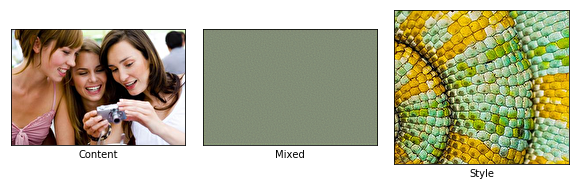

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 4.38e-11, Style: 7.61e-28, Denoise: 1.01e-07


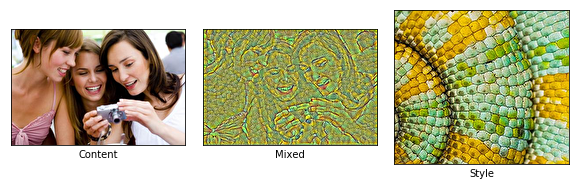

. . . . . . . . . 
Iteration: 19
Weight Adj. for Content: 3.17e-11, Style: 5.06e-28, Denoise: 7.38e-08


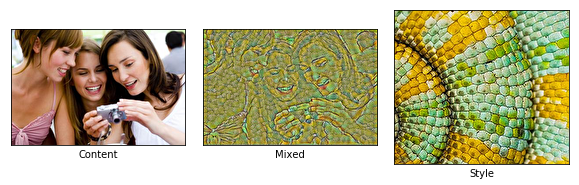


Final image:


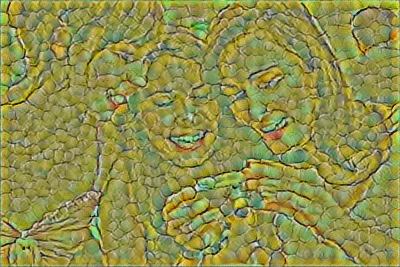

In [ ]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=20,
                     step_size=10.0)

In [ ]:
from tensorflow.python.tools import freeze_graph
freeze_graph.freeze_graph('tensorflowModel.pbtxt', "", False, 
                          './tensorflowModel.ckpt', "output/softmax",
                           "save/restore_all", "save/Const:0",
                           'stylize_quantized.pb', True, ""  
                         )